# DQN Test for Custom Enviroment for GYM from Open Ai
Example writting using Tensorflow, now using PyTorch

## Custom Enviroment

In [160]:
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import numpy as np
import random
import math
from collections import namedtuple



class ShowerEnv(Env):
  # __init__ is a special method from Gym that initializes the environment
    # action_space is a Discrete space with 3 actions: 0 for left, 1 for stay, and 2 for right
    # observation_space is a Box space with a low of 0 and a high of 100
  def __init__(self):
    self.action_space = Discrete(3)
    self.observation_space = Box(low=np.array(
        [0]), high=np.array([100]), dtype=np.float32)

    self.state = 38 + random.randint(-3, 3)
    self.shower_length = 60

  # step is a special method from Gym that takes an action and returns the next state, reward, done, and info
      # action is an integer from 0 to 2, where 0 is left, 1 is stay, and 2 is right
      # state is an integer from 0 to 100, where 0 is cold, 100 is hot, and 37 to 39 is the ideal temperature
      # reward is 1 if the temperature is ideal, and -1 otherwise
      # done is True if the shower is over, and False otherwise
      # info is an empty dictionary
  def step(self, action):
    self.state += action - 1
    self.shower_length -= 1

    if self.state >= 37 and self.state <= 39:
      reward = 1
    else:
      reward = -1

    if self.shower_length <= 0:
      done = True
    else:
      done = False

    self.state += random.randint(-1, 1)
    info = {}

    return self.state, reward, done, info

  # render is a method from Gym, that renders the environment 
  def render(self):
    pass

  # reset is a special method from Gym that resets the environment
  def reset(self):
    self.state = 38 + random.randint(-3, 3)
    self.shower_length = 60
    return [self.state], {}

### Does it pass the Stable-baseline3 checker

In [161]:
# # check_env is a method from Stable Baselines that checks if the environment is compatible with the algorithms

# from stable_baselines.common.env_checker import check_env
# check_env(ShowerEnv(), warn=True, skip_render_check=True)  



### Manual Testing

In [162]:
env = ShowerEnv()

# Manually implement the agent, to take random actions for 5 steps
for _ in range(20):
  state = env.reset()
  action = env.action_space.sample()
  state, reward, done, info = env.step(action)
  print(f"step: {_} ,state: {state}, action: {action}, reward: {reward}, done: {done}")
  if done: 
    break

step: 0 ,state: 39, action: 1, reward: -1, done: False
step: 1 ,state: 34, action: 0, reward: -1, done: False
step: 2 ,state: 35, action: 1, reward: -1, done: False
step: 3 ,state: 41, action: 0, reward: -1, done: False
step: 4 ,state: 39, action: 1, reward: -1, done: False
step: 5 ,state: 35, action: 1, reward: -1, done: False
step: 6 ,state: 39, action: 0, reward: -1, done: False
step: 7 ,state: 42, action: 1, reward: -1, done: False
step: 8 ,state: 35, action: 0, reward: -1, done: False
step: 9 ,state: 39, action: 0, reward: 1, done: False
step: 10 ,state: 42, action: 1, reward: -1, done: False
step: 11 ,state: 37, action: 1, reward: -1, done: False
step: 12 ,state: 39, action: 0, reward: 1, done: False
step: 13 ,state: 36, action: 2, reward: -1, done: False
step: 14 ,state: 42, action: 1, reward: -1, done: False
step: 15 ,state: 35, action: 2, reward: -1, done: False
step: 16 ,state: 37, action: 2, reward: 1, done: False
step: 17 ,state: 36, action: 1, reward: -1, done: False
step:

## Machine Learning

### Setting up

In [163]:
import gymnasium as gym
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib

# Use Cuda (GPU) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### Define the replay buffer

In [164]:
# Replay 
 
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer:
    # Initialize the buffer
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    # Push a new experience to the buffer
    def push(self, *args):
        ''' Save a transition to the buffer'''
        self.buffer.append(Transition(*args) )
    
    # Sample a random batch of experiences from the buffer
    def sample(self, batch_size): 
        ''' Sample a batch of experiences from the buffer'''
        return random.sample(self.buffer, batch_size)
        # states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        # return states, actions, rewards, next_states, dones
    
    # Return the length of the buffer (Maybe not neeeded)
    def __len__(self):
        return len(self.buffer)

### Define the DQN network


In [165]:
# Deep Q-Network
class DQN(nn.Module):
    # Initialize the network with 3 fully connected layers with ReLU activation functions 
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # self.layer1 = nn.Linear(n_observations, 24)  # Input layer
        # self.layer2 = nn.Linear(24, 24)  # Hidden layer
        # self.layer3 = nn.Linear(24, n_actions) # Output layer

        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Forward pass through the network 
    # The input is the state, and the output is the Q-values for each action
    def forward(self, x): 
        # x = torch.relu(self.layer1(x))
        # Explicitly cast x to float before passing to layer1
        x = torch.relu(self.layer1(x.float()))
        # x = torch.relu(self.layer2(x))
        # Explicitly cast x to float before passing to layer1
        x = torch.relu(self.layer2(x.float()))
        x = self.layer3(x)
        return x

### Hyperparameters
1. BATCH_SIZE is the number of transitions sampled from the replay buffer
2. GAMMA is the discount factor as mentioned in the previous section
3. EPS_START is the starting value of epsilon
4. EPS_END is the final value of epsilon
5. EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
6. TAU is the update rate of the target network
7. LR is the learning rate of the ``AdamW`` optimizer
8. The size of memory for the Replay Buffer

In [166]:
# Hyperparameters
# The discount factor, batch size, learning rate, target update frequency, and memory size
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
MEMORY_SIZE = 10000

### Initialize environment and DQN

In [167]:
# Initialize the environment, the policy network, the target network, and the optimizer
env = ShowerEnv()

# Get number of actions from gym action space
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions)
target_net = DQN(n_observations, n_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

steps_done = 0


### Initialize optimizer and replay buffer


In [168]:
# The optimizer is Adam with a learning rate of 0.001
optimizer = optim.Adam(policy_net.parameters(), lr=LR, amsgrad=True)

# memory is initialized with the ReplayBuffer class
memory = ReplayBuffer(MEMORY_SIZE)

### Select Action

In [169]:
# select_action function selects an action using an epsilon-greedy policy
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    
    steps_done += 1

    # Epsilon-greedy policy, where epsilon is the probability of selecting a random action
    if sample > eps_threshold: 
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1,1)
    else: 
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


### Plot Duration

In [170]:

episode_average_states = []  # List to store rewards for each episode
def plot_average_states(show_result=False):
    plt.figure(1)
    plt.clf()

    durations_t = torch.tensor(episode_average_states, dtype=torch.float)
    
    # Show if the the traning is complete
    if show_result: 
        plt.title('Average State (Temperature) per Episode')
    else: 
        plt.clf() # Clear the plot
        plt.title('Training...')
    
    # Plot the episode durations
    plt.xlabel('Episode')
    plt.ylabel('Average State (Temperature)')
    plt.plot(np.array(episode_average_states))

    plt.pause(0.001)  # pause a bit so that plots are updated

    if is_ipython: 
        if not show_result: 
            display.display(plt.gcf()) 
            display.clear_output(wait=True)
        else: 
            display.display(plt.gcf)

### Optimize Model

In [171]:
# Function that performs a single step of the optimization
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor((tuple(map(lambda s: s is not None, batch.next_state))), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])


    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)


    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)


    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(
            non_final_next_states).max(1).values
        

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # In-place graident clipping
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 100)
    optimizer.step()

### Traning Loop

Complete


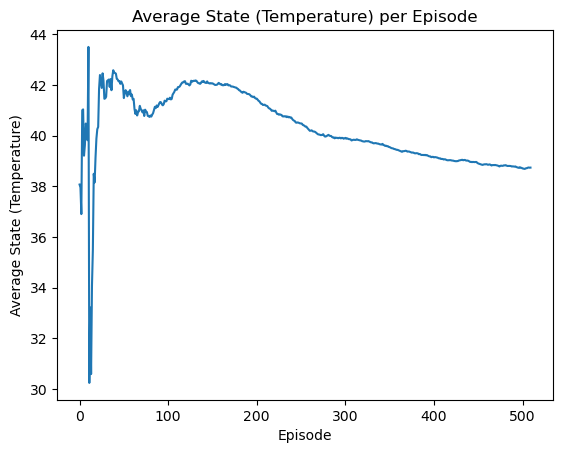

<function matplotlib.pyplot.gcf() -> 'Figure'>

In [174]:
from itertools import count

num_episodes = 500 

f = open("training_log.csv", "w")
#f.write(f" step, state, action, reward, done\n")

episode_states = []  # List to store rewards for each episode
for i_episodes in range(num_episodes): 
    # Initialize the environment and gets its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)  # Add one unsqueeze operation

    f.write(f"Episode: {i_episodes} \n")
    for t in count():
        action = select_action(state)
        state, reward, done, info = env.step(action)
        observation, reward, done, info = env.step(
            action.item())
        
        # Priting to the log file
        state_value = state.item()  # Assuming state is a single-element tensor
        action_value = action.item()
        f.write(
            f"Step: {t}, State: {state_value}, Action: {action_value}, Reward: {reward}, Done: {done} \n")
        reward = torch.tensor([reward], device=device)

        # Track episode average states
        episode_states.append(state_value) # Append the state to the list
        

        if done: 
            next_state = None
        else:
            next_state = torch.tensor([observation], dtype=torch.float32, device=device).unsqueeze(0)
        
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * \
                    TAU + target_net_state_dict[key]*(1-TAU)
            
        target_net.load_state_dict(target_net_state_dict)

        if done: 
            episode_average_state = sum(episode_states) / len(episode_states)
            episode_average_states.append(episode_average_state)
            plot_average_states()
            break

f.close()
print('Complete')
plot_average_states(show_result=True)
plt.ioff()
plt.show() 